At this stage, we have determined:
* Our chosen approach to imputing the missing features
* Our optimal models (data augmentation, PCA, sample weights, actigraph inclusion, target + eval function, model parameters) for:
    * XGBoost
    * DNN

Here, we incorporate the above, and look for the best way to combine the predictions from our models trained on the labelled data.

Options:
* single model
* simple average of multiple models
* weighted average based on confidence score of models

# Steps
1. Data import, split and preprocessing
2. Imputation of missing features
3. Create supplementary datasets and functions necessary for our models
4. Models
    * XGBoost
    * DNN
5. Aggregation approaches

In [1]:
import numpy as np
import pandas as pd

import os

import polars as pl
from glob import glob
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#from sklearn.impute import KNNImputer

#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.svm import SVR

import lightgbm as lgb

from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import matplotlib.pyplot as plt

# Data import and preprocessing

In [2]:
train_data=pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [3]:
train_data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
INPUT_DIR = "/kaggle/input/child-mind-institute-problematic-internet-use/"

# Import aggregate fields from parquet files
# Modified code from rsakata: https://www.kaggle.com/code/rsakata/cmi-piu-16th-place-solution

files_train = glob(INPUT_DIR + "series_train.parquet/*")
#if IS_SUBMIT:
#    files += glob(INPUT_DIR + "series_test.parquet/*")

list_df_train = []
for file in tqdm(files_train):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df_train.append(df_series.to_pandas())

df_series = pd.concat(list_df_train)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg_train = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg_train.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg_train.columns]
df_agg_train

  0%|          | 0/996 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807
2,00f332d1,-3.071176,0.927238,3.249122,0.463244,1.138379,2.939823
3,01085eb3,-2.902040,0.791255,3.389762,0.315061,1.054698,2.185839
4,012cadd8,-2.806918,1.171675,3.337322,0.388409,0.823770,3.350365
...,...,...,...,...,...,...,...
964,fe9c71d8,-3.116904,0.961804,3.037607,0.943554,-0.394200,2.742634
965,fecc07d6,-3.969482,0.981531,1.332831,1.428363,-0.438018,1.795653
966,ff18b749,-2.820076,0.937540,3.258458,0.417267,1.236652,3.341580
967,ffcd4dbd,-3.271800,0.827489,3.183395,0.629553,0.521227,2.665325


In [5]:
train_data2 = train_data.merge(df_agg_train, how="left", on="id")
train_data2.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.0,Winter,0.0,1.0,-4.000377,NaN,1.989905,NaN,0.051475,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
files_test = glob(INPUT_DIR + "series_test.parquet/*")


list_df_test = []
for file in tqdm(files_test):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df_test.append(df_series.to_pandas())

df_series = pd.concat(list_df_test)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg_test = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg_test.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg_test.columns]
df_agg_test

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807


In [7]:
test_data2 = test_data.merge(df_agg_test, how="left", on="id")
test_data2.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,31.0,45.0,Winter,0.0,-4.000377,NaN,1.989905,NaN,0.051475,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
X_train = train_data2[['Basic_Demos-Age',
                      'Basic_Demos-Sex',
                      'CGAS-CGAS_Score',
                      'Physical-BMI',
                      'BIA-BIA_BMI',
                      'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP',
                      'Physical-HeartRate',
                      'Physical-Systolic_BP',
                      'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins',
                      'Fitness_Endurance-Time_Sec',
                      'FGC-FGC_CU_Zone',
                      'FGC-FGC_GSND_Zone',
                      'FGC-FGC_GSD_Zone',
                      'FGC-FGC_PU_Zone',
                      'FGC-FGC_SRL_Zone',
                      'FGC-FGC_SRR_Zone',
                      'FGC-FGC_TL_Zone',
                      'BIA-BIA_Activity_Level_num',
                      'BIA-BIA_BMC',
                      'BIA-BIA_BMR',
                      'BIA-BIA_DEE',
                      'BIA-BIA_ECW',
                      'BIA-BIA_FFM',
                      'BIA-BIA_FFMI',
                      'BIA-BIA_FMI',
                      'BIA-BIA_Fat',
                      'BIA-BIA_ICW',
                      'BIA-BIA_LDM',
                      'BIA-BIA_LST',
                      'BIA-BIA_SMM',
                      'BIA-BIA_TBW',
                      'PAQ_A-PAQ_A_Total',
                      'PAQ_C-PAQ_C_Total',
                      'SDS-SDS_Total_T',
                      'PreInt_EduHx-computerinternet_hoursday'
                       ,
                      'enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'
                      ]]

y_train = train_data2['PCIAT-PCIAT_Total']

X_test = test_data2[['Basic_Demos-Age',
                      'Basic_Demos-Sex',
                      'CGAS-CGAS_Score',
                      'Physical-BMI',
                      'BIA-BIA_BMI',
                      'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP',
                      'Physical-HeartRate',
                      'Physical-Systolic_BP',
                      'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins',
                      'Fitness_Endurance-Time_Sec',
                      'FGC-FGC_CU_Zone',
                      'FGC-FGC_GSND_Zone',
                      'FGC-FGC_GSD_Zone',
                      'FGC-FGC_PU_Zone',
                      'FGC-FGC_SRL_Zone',
                      'FGC-FGC_SRR_Zone',
                      'FGC-FGC_TL_Zone',
                      'BIA-BIA_Activity_Level_num',
                      'BIA-BIA_BMC',
                      'BIA-BIA_BMR',
                      'BIA-BIA_DEE',
                      'BIA-BIA_ECW',
                      'BIA-BIA_FFM',
                      'BIA-BIA_FFMI',
                      'BIA-BIA_FMI',
                      'BIA-BIA_Fat',
                      'BIA-BIA_ICW',
                      'BIA-BIA_LDM',
                      'BIA-BIA_LST',
                      'BIA-BIA_SMM',
                      'BIA-BIA_TBW',
                      'PAQ_A-PAQ_A_Total',
                      'PAQ_C-PAQ_C_Total',
                      'SDS-SDS_Total_T',
                      'PreInt_EduHx-computerinternet_hoursday'
                      ,
                      'enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'
                   ]]

In [9]:
# Add this only if we are not interested in the actigraph data

X_train = X_train.drop(columns=['enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'])

X_test = X_test.drop(columns=['enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'])


In [10]:
# Add calculated fields
X_train['Physical-BMI_Calc'] = X_train.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
X_train['Fitness_Endurance-Time_Sec_Calc'] = X_train.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
X_train['PAQ_Total'] = X_train.apply(lambda row: row['PAQ_A-PAQ_A_Total'] if row['PAQ_A-PAQ_A_Total']==row['PAQ_A-PAQ_A_Total'] else row['PAQ_C-PAQ_C_Total'],axis=1)


# Drop fields no longer needed
X_train = X_train.drop(columns=['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total',
                     'Physical-BMI','BIA-BIA_BMI',
                     'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec'])

# Remove outliers - may give warnings due to NaN value comparison
X_train.loc[X_train['CGAS-CGAS_Score']>=100.0,'CGAS-CGAS_Score'] = np.nan
X_train.loc[X_train['Physical-Systolic_BP']>=180.0,'Physical-Systolic_BP'] = np.nan
X_train.loc[X_train['Physical-Diastolic_BP']>=120.0,'Physical-Diastolic_BP'] = np.nan
X_train.loc[X_train['BIA-BIA_DEE']>=6000.0,'BIA-BIA_DEE'] = np.nan
X_train.loc[(X_train['BIA-BIA_BMC']<=0.0) | (X_train['BIA-BIA_BMC']>=16.0),'BIA-BIA_BMC'] = np.nan
X_train.loc[(X_train['BIA-BIA_BMR']<=0.0) | (X_train['BIA-BIA_BMR']>=2400.0),'BIA-BIA_BMR'] = np.nan
X_train.loc[(X_train['BIA-BIA_ECW']<=0.0) | (X_train['BIA-BIA_ECW']>=60.0),'BIA-BIA_ECW'] = np.nan
X_train.loc[(X_train['BIA-BIA_FFM']<=0.0) | (X_train['BIA-BIA_FFM']>=200.0),'BIA-BIA_FFM'] = np.nan
X_train.loc[(X_train['BIA-BIA_FFMI']<=0.0) | (X_train['BIA-BIA_FFMI']>=25.0),'BIA-BIA_FFMI'] = np.nan
X_train.loc[(X_train['BIA-BIA_FMI']<=0.0) | (X_train['BIA-BIA_FMI']>=25.0),'BIA-BIA_FMI'] = np.nan
X_train.loc[(X_train['BIA-BIA_Fat']<=8.0) | (X_train['BIA-BIA_Fat']>=60.0),'BIA-BIA_Fat'] = np.nan
X_train.loc[(X_train['BIA-BIA_ICW']<=0.0) | (X_train['BIA-BIA_ICW']>=80.0),'BIA-BIA_ICW'] = np.nan
X_train.loc[(X_train['BIA-BIA_LDM']<=0.0) | (X_train['BIA-BIA_LDM']>=60.0),'BIA-BIA_LDM'] = np.nan
X_train.loc[(X_train['BIA-BIA_LST']<=0.0) | (X_train['BIA-BIA_LST']>=150.0),'BIA-BIA_LST'] = np.nan
X_train.loc[(X_train['BIA-BIA_SMM']<=0.0) | (X_train['BIA-BIA_SMM']>=100.0),'BIA-BIA_SMM'] = np.nan
X_train.loc[(X_train['BIA-BIA_TBW']<=0.0) | (X_train['BIA-BIA_TBW']>=150.0),'BIA-BIA_TBW'] = np.nan

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pan

# Missing feature imputation

In [11]:
# Noting number of missing features
# Different weight approaches
features_missing_labelled = X_train.loc[y_train.notna()].isnull().sum(axis=1)/X_train.shape[1]
weights_labelled = 1 - features_missing_labelled
weights_labelled.shape

features_missing_labelled2 = X_train.loc[y_train.notna()].isnull().sum(axis=1)
weights_labelled2 = 1 * ((0.95)**features_missing_labelled2)

weights_labelled3 = np.exp((-2)*features_missing_labelled)

In [12]:
#MICE
iter_imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_fimpute = pd.DataFrame(iter_imputer.fit_transform(X_train), columns = X_train.columns)
X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,10.433586,0.372727,64.818333,26.974426,69.403169,81.519388,116.805724,4.974030,0.480343,1.849340,...,31.365619,18.066786,63.749033,31.477558,50.138601,57.881433,1.073783,19.374281,468.721596,2.537644
std,3.574648,0.483591,9.805846,4.770202,11.011760,12.021296,14.228391,0.935015,0.389401,0.346190,...,7.099089,5.021442,18.068724,10.250420,13.839926,10.737030,1.022870,4.520383,89.856113,0.653839
min,5.000000,0.000000,-23.164846,4.967856,0.000000,27.000000,0.000000,0.000000,-0.172314,-1.772537,...,14.489000,4.635810,23.620100,4.655730,20.589200,38.000000,-0.278053,0.000000,5.000000,0.580000
25%,8.000000,0.000000,60.000000,24.000000,64.000000,74.477915,109.000000,4.865377,0.000000,1.766934,...,28.665882,16.394825,56.747700,27.190300,44.819225,51.000000,0.000000,16.485531,450.588541,2.150000
50%,10.000000,0.000000,64.765661,26.137776,69.000000,81.485260,115.604545,4.973005,0.485209,1.872825,...,31.347850,18.058831,63.734357,30.792758,50.135566,57.770115,1.000000,18.589876,469.207021,2.567600
75%,13.000000,1.000000,70.000000,29.035484,73.000000,87.000000,122.000000,5.081351,1.000000,2.000000,...,32.689978,18.232694,63.917532,33.007979,50.147145,60.000000,2.000000,21.015855,487.415981,2.886522
max,22.000000,1.000000,95.000000,56.944991,119.000000,138.000000,179.000000,28.000000,1.129295,3.000000,...,86.587578,52.527500,188.145259,111.835754,146.075000,100.000000,3.019946,59.132048,2154.275365,4.790000


In [13]:
# Clip imputed values to original max and min
for column in X_train_fimpute.columns:
    max_val = np.max(X_train[column])
    min_val = np.min(X_train[column])
    X_train_fimpute.loc[X_train_fimpute[column]>max_val,column] = max_val
    X_train_fimpute.loc[X_train_fimpute[column]<min_val, column] = min_val

X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,10.433586,0.372727,64.830496,26.998653,69.403169,81.519388,116.805724,4.974030,0.480419,1.850041,...,31.363445,18.066786,63.672368,31.469451,50.138601,57.881433,1.073848,19.374281,468.480618,2.537644
std,3.574648,0.483591,9.726235,4.692420,11.011760,12.021296,14.228391,0.935015,0.389164,0.341634,...,7.083395,5.021442,17.644465,10.193245,13.839926,10.737030,1.022777,4.520383,86.553515,0.653839
min,5.000000,0.000000,25.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,1.000000,...,14.489000,4.635810,23.620100,4.655730,20.589200,38.000000,0.000000,0.000000,5.000000,0.580000
25%,8.000000,0.000000,60.000000,24.000000,64.000000,74.477915,109.000000,4.865377,0.000000,1.766934,...,28.665882,16.394825,56.747700,27.190300,44.819225,51.000000,0.000000,16.485531,450.588541,2.150000
50%,10.000000,0.000000,64.765661,26.137776,69.000000,81.485260,115.604545,4.973005,0.485209,1.872825,...,31.347850,18.058831,63.734357,30.792758,50.135566,57.770115,1.000000,18.589876,469.207021,2.567600
75%,13.000000,1.000000,70.000000,29.035484,73.000000,87.000000,122.000000,5.081351,1.000000,2.000000,...,32.689978,18.232694,63.917532,33.007979,50.147145,60.000000,2.000000,21.015855,487.415981,2.886522
max,22.000000,1.000000,95.000000,50.000000,119.000000,138.000000,179.000000,28.000000,1.000000,3.000000,...,79.473800,52.527500,149.830000,97.923100,146.075000,100.000000,3.000000,59.132048,1200.000000,4.790000


In [14]:
# standardise data
scaler = StandardScaler()                  

X_train_fimpute[X_train_fimpute.columns] = scaler.fit_transform(X_train_fimpute[X_train_fimpute.columns])
X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,...,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03
mean,-1.928872e-16,-5.831474e-17,3.117596e-16,1.327782e-16,-1.007499e-15,-8.594696e-16,6.488637e-16,-3.597571e-16,3.992317e-17,2.224932e-16,...,-3.445056e-16,-4.270434e-16,9.509789e-17,9.868649e-17,-1.417497e-16,-3.588600e-17,1.202181e-16,-1.076580e-16,-1.009294e-16,1.722528e-16
std,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,...,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00
min,-1.520226e+00,-7.708456e-01,-4.095678e+00,-1.917942e+00,-6.303437e+00,-4.535807e+00,-8.210378e+00,-5.320405e+00,-1.234646e+00,-2.488480e+00,...,-2.382555e+00,-2.675063e+00,-2.270249e+00,-2.630870e+00,-2.135353e+00,-1.851904e+00,-1.050066e+00,-4.286523e+00,-5.355521e+00,-2.994454e+00
25%,-6.808763e-01,-7.708456e-01,-4.967088e-01,-6.391228e-01,-4.907346e-01,-5.858239e-01,-5.486713e-01,-1.162191e-01,-1.234646e+00,-2.432944e-01,...,-3.808772e-01,-3.330064e-01,-3.925051e-01,-4.198556e-01,-3.843986e-01,-6.409875e-01,-1.050066e+00,-6.391307e-01,-2.067430e-01,-5.929485e-01
50%,-1.213100e-01,-7.708456e-01,-6.666870e-03,-1.834846e-01,-3.661724e-02,-2.839394e-03,-8.443191e-02,-1.096752e-03,1.230970e-02,6.669983e-02,...,-2.201944e-03,-1.584385e-03,3.513669e-03,-6.639477e-02,-2.193509e-04,-1.036897e-02,-7.221268e-02,-1.735482e-01,8.393590e-03,4.582070e-02
75%,7.180394e-01,1.297277e+00,5.315681e-01,4.341231e-01,3.266766e-01,4.559661e-01,3.651103e-01,1.147948e-01,1.335289e+00,4.390013e-01,...,1.872972e-01,3.304415e-02,1.389641e-02,1.509551e-01,6.174196e-04,1.973390e-01,9.056408e-01,3.631950e-01,2.187982e-01,5.336514e-01
max,3.236088e+00,1.297277e+00,3.102260e+00,4.902428e+00,4.504556e+00,4.698973e+00,4.371691e+00,2.462942e+01,1.335289e+00,3.366482e+00,...,6.792848e+00,6.863580e+00,4.883600e+00,6.520204e+00,6.932733e+00,3.923235e+00,1.883494e+00,8.796331e+00,8.452710e+00,3.445252e+00


In [15]:
# Repeat the above for X_test

# Add calculated fields
X_test['Physical-BMI_Calc'] = X_test.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
X_test['Fitness_Endurance-Time_Sec_Calc'] = X_test.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
X_test['PAQ_Total'] = X_test.apply(lambda row: row['PAQ_A-PAQ_A_Total'] if row['PAQ_A-PAQ_A_Total']==row['PAQ_A-PAQ_A_Total'] else row['PAQ_C-PAQ_C_Total'],axis=1)

# Drop fields no longer needed
X_test = X_test.drop(columns=['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total',
                     'Physical-BMI','BIA-BIA_BMI',
                     'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec'])

# Remove outliers
X_test.loc[X_test['CGAS-CGAS_Score']>=100.0,'CGAS-CGAS_Score'] = np.nan
X_test.loc[X_test['Physical-Systolic_BP']>=180.0,'Physical-Systolic_BP'] = np.nan
X_test.loc[X_test['Physical-Diastolic_BP']>=120.0,'Physical-Diastolic_BP'] = np.nan
X_test.loc[X_test['BIA-BIA_DEE']>=6000.0,'BIA-BIA_DEE'] = np.nan
X_test.loc[(X_test['BIA-BIA_BMC']<=0.0) | (X_test['BIA-BIA_BMC']>=16.0),'BIA-BIA_BMC'] = np.nan
X_test.loc[(X_test['BIA-BIA_BMR']<=0.0) | (X_test['BIA-BIA_BMR']>=2400.0),'BIA-BIA_BMR'] = np.nan
X_test.loc[(X_test['BIA-BIA_ECW']<=0.0) | (X_test['BIA-BIA_ECW']>=60.0),'BIA-BIA_ECW'] = np.nan
X_test.loc[(X_test['BIA-BIA_FFM']<=0.0) | (X_test['BIA-BIA_FFM']>=200.0),'BIA-BIA_FFM'] = np.nan
X_test.loc[(X_test['BIA-BIA_FFMI']<=0.0) | (X_test['BIA-BIA_FFMI']>=25.0),'BIA-BIA_FFMI'] = np.nan
X_test.loc[(X_test['BIA-BIA_FMI']<=0.0) | (X_test['BIA-BIA_FMI']>=25.0),'BIA-BIA_FMI'] = np.nan
X_test.loc[(X_test['BIA-BIA_Fat']<=8.0) | (X_test['BIA-BIA_Fat']>=60.0),'BIA-BIA_Fat'] = np.nan
X_test.loc[(X_test['BIA-BIA_ICW']<=0.0) | (X_test['BIA-BIA_ICW']>=80.0),'BIA-BIA_ICW'] = np.nan
X_test.loc[(X_test['BIA-BIA_LDM']<=0.0) | (X_test['BIA-BIA_LDM']>=60.0),'BIA-BIA_LDM'] = np.nan
X_test.loc[(X_test['BIA-BIA_LST']<=0.0) | (X_test['BIA-BIA_LST']>=150.0),'BIA-BIA_LST'] = np.nan
X_test.loc[(X_test['BIA-BIA_SMM']<=0.0) | (X_test['BIA-BIA_SMM']>=100.0),'BIA-BIA_SMM'] = np.nan
X_test.loc[(X_test['BIA-BIA_TBW']<=0.0) | (X_test['BIA-BIA_TBW']>=150.0),'BIA-BIA_TBW'] = np.nan

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pan

In [16]:
# Imputation
X_test_fimpute = pd.DataFrame(iter_imputer.transform(X_test), columns = X_test.columns)

# Clipping
for column in X_test_fimpute.columns:
    max_val = np.max(X_train[column])
    min_val = np.min(X_train[column])
    X_test_fimpute.loc[X_test_fimpute[column]>max_val,column] = max_val
    X_test_fimpute.loc[X_test_fimpute[column]<min_val, column] = min_val

# Scaling
X_test_fimpute[X_test_fimpute.columns] = scaler.transform(X_test_fimpute[X_test_fimpute.columns])

X_test_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.088527,0.056403,-0.045878,0.062078,-0.054532,-0.024661,0.096746,-0.099940,-0.092855,-0.200219,...,-0.201746,-0.212473,-0.149911,-0.186412,-0.143597,-0.248715,0.397885,0.159731,-0.138408,-0.321769
std,1.042416,1.039489,0.801382,0.834813,0.728397,0.630397,1.095310,0.609631,1.064675,0.889571,...,0.502229,0.550313,0.534173,0.543307,0.553989,0.532311,1.029494,0.885501,0.532543,1.215554
min,-1.520226,-0.770846,-1.524986,-1.917942,-1.126499,-0.958369,-1.532744,-1.982608,-1.234646,-2.488480,...,-1.458277,-1.826683,-1.403148,-1.575630,-1.668095,-1.665609,-1.050066,-1.181175,-1.577034,-2.290828
25%,-0.401093,-0.770846,-0.398352,-0.639123,-0.626970,-0.479991,-0.323267,-0.117460,-1.234646,-0.271335,...,-0.353243,-0.152373,-0.072266,-0.321185,-0.053025,-0.384832,-0.316676,-0.484882,-0.194965,-0.793831
50%,-0.121310,-0.770846,0.053470,0.186887,0.013374,-0.096653,0.013656,-0.010524,-0.226210,-0.084495,...,-0.172489,-0.012274,0.001130,-0.057763,-0.000024,-0.036684,0.905641,0.059206,-0.060167,-0.247979
75%,0.508202,1.297277,0.442934,0.601290,0.157655,0.349696,0.359988,0.109218,1.335289,0.310675,...,0.143634,0.007697,0.007959,0.164501,0.000693,0.043558,0.934083,0.438107,0.054259,0.197350
max,2.396738,1.297277,1.559845,1.827300,2.099974,1.287928,3.247037,1.097415,1.335289,1.002945,...,0.662726,0.564693,0.908379,0.466422,0.938556,0.569929,1.883494,2.371861,1.253942,2.405109


# Prepare datasets and functions for models
* Labelled data set
* Augmented data sets - X, y, weights
* PCA
* sii target
* QWK custom metrics
* QWK custom loss/objective functions

## Labelled data set

In [17]:
X_train_labelled = X_train_fimpute.loc[y_train.notna()]
y_train_labelled = y_train[y_train.notna()]
print("Size of labelled train data set is: ", (X_train_labelled.shape, y_train_labelled.shape))

Size of labelled train data set is:  ((2736, 34), (2736,))


In [18]:
# Since we are not using the unlabelled data in this notebook, we can drop the indices
# This will help us prevent any accidents when doing cross-validation when we split by index, don't have to think about loc vs iloc etc.

X_train_labelled = X_train_labelled.reset_index(drop=True)
y_train_labelled = y_train_labelled.reset_index(drop=True)

In [19]:
weights_labelled = weights_labelled.reset_index(drop=True)
weights_labelled2 = weights_labelled2.reset_index(drop=True)
weights_labelled3 = weights_labelled3.reset_index(drop=True)

## Augmented data

In [20]:
# X datasets - X_train_labelled, X_train_labelled_aug1a, X_train_labelled_aug1b, X_train_labelled_aug2a, X_train_labelled_aug2b
# aug1/aug2 - augment once or twice
# a/b - 0.1 noise multiplier, 0.15 noise multiplier

# Augmented data

# Get standard deviations of each column in X and y
std_X = np.std(X_train_labelled, axis=0)
std_y = np.std(y_train_labelled, axis=0)

# Create augmented datasets

X_noise_multiplier=0.1
y_noise_multiplier=0.1

# Deliberately not doing this in a for loop because we will not augment more than twice
# For ease of understanding the datasets being created
# And we may choose to add different noisiness to each augmentation
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug1a = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1a = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug1a.shape, y_train_labelled_aug1a.shape)

#repeat
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug2a = pd.concat([X_train_labelled_aug1a,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug2a = pd.concat([y_train_labelled_aug1a,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug2a.shape, y_train_labelled_aug2a.shape)


# Increased noise multiplier
X_noise_multiplier=0.15
y_noise_multiplier=0.15

X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug1b = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1b = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug1b.shape, y_train_labelled_aug1b.shape)

#repeat
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug2b = pd.concat([X_train_labelled_aug1b,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug2b = pd.concat([y_train_labelled_aug1b,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug2b.shape, y_train_labelled_aug2b.shape)


X_noise_multiplier=0.2
y_noise_multiplier=0.2

X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug1c = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1c = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug1c.shape, y_train_labelled_aug1c.shape)

#repeat
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug2c = pd.concat([X_train_labelled_aug1c,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug2c = pd.concat([y_train_labelled_aug1c,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug2c.shape, y_train_labelled_aug2c.shape)


(5472, 34) (5472,)
(8208, 34) (8208,)
(5472, 34) (5472,)
(8208, 34) (8208,)
(5472, 34) (5472,)
(8208, 34) (8208,)


In [21]:
# Weights. We already have defined weights_labelled, weights_labelled2, weights_labelled3
# Just need to augment

weights_labelled_aug1 = pd.concat([weights_labelled, weights_labelled], ignore_index=True)
weights_labelled_aug2 = pd.concat([weights_labelled_aug1, weights_labelled], ignore_index=True)
print(weights_labelled_aug1.shape, weights_labelled_aug2.shape)

weights_labelled2_aug1 = pd.concat([weights_labelled2, weights_labelled2], ignore_index=True)
weights_labelled2_aug2 = pd.concat([weights_labelled2_aug1, weights_labelled2], ignore_index=True)
print(weights_labelled2_aug1.shape, weights_labelled2_aug2.shape)

weights_labelled3_aug1 = pd.concat([weights_labelled3, weights_labelled3], ignore_index=True)
weights_labelled3_aug2 = pd.concat([weights_labelled3_aug1, weights_labelled3], ignore_index=True)
print(weights_labelled3_aug1.shape, weights_labelled3_aug2.shape)

(5472,) (8208,)
(5472,) (8208,)
(5472,) (8208,)


## PCA

In [22]:
pca = PCA(n_components=25)

X_train_labelled_pca = pd.DataFrame(pca.fit_transform(X_train_labelled))
X_test_pca = pd.DataFrame(pca.transform(X_test_fimpute))
X_train_labelled_pca_aug1b = pd.DataFrame(pca.transform(X_train_labelled_aug1b))
X_train_labelled_pca_aug2b = pd.DataFrame(pca.transform(X_train_labelled_aug2b))

print(X_train_labelled_pca.shape, X_test_pca.shape, X_train_labelled_pca_aug1b.shape, X_train_labelled_pca_aug2b.shape)

(2736, 25) (20, 25) (5472, 25) (8208, 25)


## sii target data

In [23]:
y_train_labelled_sii = y_train_labelled.copy()
y_train_labelled_sii.name='sii'
y_train_labelled_sii = y_train_labelled_sii.apply(lambda row: 0 if row<=30 else 
                             (1 if row<50 else (
                                2 if row<80 else (3)
                            )))

y_train_labelled_sii_aug1 = pd.concat([y_train_labelled_sii, y_train_labelled_sii], ignore_index=True)
y_train_labelled_sii_aug2 = pd.concat([y_train_labelled_sii_aug1, y_train_labelled_sii], ignore_index=True)

# Not using our alternative binned target, as it did not improve results

## XGBoost custom QWK

[3.11764706 1.17647059 1.23529412 3.29411765]
[3.1109, 1.1709, 1.2309, 3.2908999999999997]


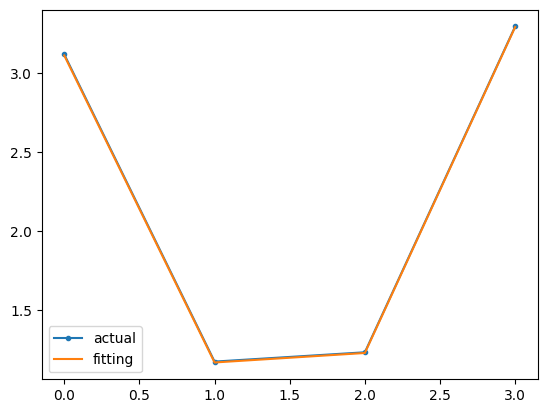

In [24]:
# Custom qwk metric and loss function for pciat_sii
#Modified from https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa
y = np.array([0,1,2,1,1,2,3,3,2,3,2,1,2,1,0,1,0])

c = 1.47
d = 0.95

g = np.zeros(4)
for i in range(4):
    g[i] = ((y - i)**2).mean()
    #g[i] = i

print(g)
h = [(x-c)**2 + d for x in [0,1,2,3]]
print(h)

plt.plot([0,1,2,3], g, marker=".", label="actual")
plt.plot([0,1,2,3], [(x-c)**2 + d for x in [0,1,2,3]], label="fitting")
plt.legend()
plt.show()

In [25]:
# Metric for XGB - not used
'''
def quadratic_weighted_kappa_sii(y_true, y_pred):
    if isinstance(y_pred, xgb.QuantileDMatrix):
        # XGB
        y_true, y_pred = y_pred, y_true

        y_true = (y_true.get_label() + c).round()
        y_pred = (y_pred + c).clip(0, 3).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk

    else:
        # For LightGBM
        y_true = y_true + c
        y_pred = (y_pred + c).clip(0, 3).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk, True
'''

# Objective function for both XGB and LGB
def qwk_obj_sii(y_true, y_pred):
    labels = y_true + c
    preds = y_pred + c
    preds = preds.clip(0, 3)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-c)**2+d)
    df = preds - labels
    dg = preds - c
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess

## DNN custom QWK

DNN y_true and y_pred are passed as tensors, unlike for XGBoost. So different definitions are required.

In [26]:
# Weight matrix for QWK calculation
W = np.zeros((4, 4))
for i in range(len(W)):
    for j in range(len(W)):
        W[i][j] = float(((i-j)**2)/((4)-1)**2)

print(W)

[[0.         0.11111111 0.44444444 1.        ]
 [0.11111111 0.         0.11111111 0.44444444]
 [0.44444444 0.11111111 0.         0.11111111]
 [1.         0.44444444 0.11111111 0.        ]]


In [27]:
# Given a confusion matrix, compute the expected matrix from the outer product of the row and column frequencies
def compute_expected_matrix(conf_matrix):
    row_sums = tf.reduce_sum(conf_matrix, axis=1, keepdims=True)
    col_sums = tf.reduce_sum(conf_matrix, axis=0, keepdims=True)
    
    # Normalize the row and column sums by the total sum of the confusion matrix
    total_sum = tf.reduce_sum(conf_matrix)
    
    # Compute the expected matrix by multiplying the row and column marginals and normalizing
    expected_matrix = (row_sums @ col_sums) / total_sum
    
    return expected_matrix

In [28]:
# Metric for tracking model as it is trained
# Writing own QWK score function. Gradients not necessary as this is not the loss function
def qwk_sii(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 0, 3)
    y_true = tf.squeeze(y_true)
    y_pred = tf.squeeze(y_pred)

    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)

    confusion_matrix = tf.math.confusion_matrix(tf.cast(y_true, tf.int32), tf.cast(y_pred, tf.int32), num_classes=4)    
    expected_matrix = compute_expected_matrix(confusion_matrix)
    #print(confusion_matrix)
    confusion_matrix = confusion_matrix / tf.reduce_sum(confusion_matrix)
    expected_matrix = expected_matrix / tf.reduce_sum(expected_matrix)
    weight_matrix = tf.cast(tf.constant(W),tf.float32) # W defined for 4 classes
    numerator = tf.reduce_sum(weight_matrix * tf.cast(confusion_matrix, tf.float32))
    denominator = tf.reduce_sum(weight_matrix * tf.cast(expected_matrix, tf.float32))

    weighted_kappa = 1 - (numerator / denominator)

    #print(confusion_matrix)
    #print(expected_matrix)
    #print(weight_matrix)

    #E = np.outer(W, confusion)

    return weighted_kappa

In [29]:
@tf.custom_gradient
def custom_confusion_matrix_loss(y_true, y_pred):
    # Clip predictions to the range [0, 3] to calculate confusion matrix
    # Not overwriting y_true and y_pred so they can be passed as is to the gradient func
    y_pred = tf.clip_by_value(y_pred, 0, 3)
    y_true2 = tf.squeeze(y_true)  # Flatten to 1D, e.g., expecting (64,) instead of (64,1)
    y_pred2 = tf.squeeze(y_pred)  # Flatten to 1D
    
    # Round the true and predicted values: 0, 1, 2, 3
    y_true2 = tf.round(y_true2)
    y_pred2 = tf.round(y_pred2)

    # Compute the confusion matrix O
    confusion_matrix = tf.math.confusion_matrix(tf.cast(y_true2, tf.int32), tf.cast(y_pred2, tf.int32), num_classes=4)

    # Compute the expected matrix E
    expected_matrix = compute_expected_matrix(confusion_matrix)

    # Normalize confusion matrix and expected matrix
    confusion_matrix = confusion_matrix / tf.reduce_sum(confusion_matrix)
    expected_matrix = expected_matrix / tf.reduce_sum(expected_matrix)

    # Multiply by weight matrix
    numerator = tf.reduce_sum(W * tf.cast(confusion_matrix, tf.float32))
    denominator = tf.reduce_sum(W * tf.cast(expected_matrix, tf.float32))

    weighted_kappa = 1 - numerator / denominator
    
    # Forward pass (return the loss)
    def grad(dy):
        # Approximate gradient function using c and d determined previously
        # Referring to: https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa
        labels = y_true + c
        preds = y_pred + c
        #print(labels.shape, preds.shape)
        preds = tf.clip_by_value(preds, 0, 3)
        #print(labels.shape, preds.shape)
        f = 1 / 2 * tf.reduce_sum((preds - labels) ** 2)
        #print("f: ", f)
        g = 1 / 2 * tf.reduce_sum((preds - c) ** 2 + d)
        #print("g: ", g)

        df = preds - labels
        #print("df: ", df)
        dg = preds - c
        #print("dg: ", dg)
        grad = (df / g - f * dg / g ** 2) * tf.cast(tf.size(labels), tf.float32)
        #print("grad: ", grad)
        #grad = (df/g - f*dg/g**2)*len()

        grad_loss = dy * (grad) #Passing gradient multiplication

        # Experienced problems with exploding gradients, so clipping
        # Can clip all gradients to -1,1, or scale them by a consistent factor
        #grad_loss = tf.clip_by_value(grad_loss, -1, 1)
        clipping_factor = tf.reduce_max(tf.abs(grad_loss)) # Max gradient change
        #print("clipping factor: ", clipping_factor)

        #if clipping_factor>1:
        #    grad_loss = grad_loss / clipping_factor

        grad_loss = grad_loss / clipping_factor

        #return grad, grad
        #print("grad loss: ", grad_loss)
        #print("shapes: ", (y_true.shape, y_pred.shape), (grad_loss.shape, grad_loss.shape))
        return grad_loss, grad_loss  # Gradients for y_true, y_pred

    return (1 - weighted_kappa), grad # (1 - weighted_kappa) to treat as a loss function
    #return weighted_kappa, grad

In [30]:
def quadratic_weighted_kappa_sii(y_true, y_pred):
    return custom_confusion_matrix_loss(y_true, y_pred)

class QWKLoss(tf.keras.losses.Loss):
    def __init__(self, name="QWKLoss"):
        super().__init__(name=name)
    
    def call(self, y_true, y_pred):
        return quadratic_weighted_kappa_sii(y_true, y_pred)
        #return soft_quadratic_weighted_kappa(y_true, y_pred)

# Models

## XGBoost

In [31]:
# QWK objective function
xgb_model = XGBRegressor(random_state=42, objective=qwk_obj_sii, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7)

In [32]:
# Train on non-augmented data, with exponential weights
xgb_model.fit(X_train_labelled, y_train_labelled_sii, sample_weight=weights_labelled3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None,
             objective=<function qwk_obj_sii at 0x787a35f81c60>, ...)

## LightGBM

In [33]:
lgbm_model = lgb.LGBMRegressor(objective=qwk_obj_sii, metric='l2', boosting_type='gbdt',
                              num_leaves=31, learning_rate=0.01, n_estimators=300,
                              subsample=0.8, colsample_bytree=0.8)

In [34]:
lgbm_model.fit(X_train_labelled_aug2b,y_train_labelled_sii_aug2, sample_weight=weights_labelled3_aug2)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 8208, number of used features: 34
[LightGBM] [Info] Using self-defined objective function


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, metric='l2',
              n_estimators=300,
              objective=<function qwk_obj_sii at 0x787a35f81c60>,
              subsample=0.8)

## DNN

In [35]:
k = 3  # Number of folds for cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Set shuffle=True to randomize data splits

In [36]:
def create_dnn_model():
    model = keras.models.Sequential([
        keras.layers.Dense(24, input_shape=(X_train_labelled_pca.shape[1],), activation="selu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(20, activation="selu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(10, activation="selu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(1, activation="linear")
    ])

    model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mae','mse'])
    return model

In [37]:
# Prepare to store results
#validation_qwk = []
validation_losses = []
dnn_models = []

# Loop over each fold
for train_index, val_index in kf.split(X_train_labelled_pca_aug2b):
    # Split the data into training and validation sets for the current fold
    X_train_t, X_train_v = X_train_labelled_pca_aug2b.loc[train_index], X_train_labelled_pca_aug2b.loc[val_index]
    y_train_t, y_train_v = y_train_labelled_aug2b.loc[train_index], y_train_labelled_aug2b.loc[val_index]
    
    # Build a new model for each fold
    dnn_model = create_dnn_model()
    
    # Define early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Train the model on the training set and evaluate on the validation set
    history = dnn_model.fit(
        X_train_t, y_train_t,
        validation_data=(X_train_v, y_train_v),
        epochs=200,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=2
    )
    
    # Evaluate the model on the validation set
    val_loss, val_mae, val_mse = dnn_model.evaluate(X_train_v, y_train_v, verbose=2)
    #val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    #validation_qwk.append(val_qwk)
    validation_losses.append(val_loss)
    dnn_models.append(dnn_model)

# Calculate the average validation loss across all folds
#avg_val_qwk = np.mean(validation_qwk)
avg_val_loss = np.mean(validation_losses)
#print(f"Average Validation QWK: {avg_val_qwk}, Average Validation Loss: {avg_val_loss}")
print(f"Average Validation Loss: {avg_val_loss}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
86/86 - 2s - 23ms/step - loss: 639.5644 - mae: 19.7700 - mse: 639.5644 - val_loss: 379.0045 - val_mae: 15.3317 - val_mse: 379.0045
Epoch 2/200
86/86 - 0s - 3ms/step - loss: 409.9875 - mae: 15.9117 - mse: 409.9875 - val_loss: 329.9647 - val_mae: 14.3372 - val_mse: 329.9647
Epoch 3/200
86/86 - 0s - 3ms/step - loss: 374.6690 - mae: 15.2275 - mse: 374.6690 - val_loss: 322.0424 - val_mae: 14.1722 - val_mse: 322.0424
Epoch 4/200
86/86 - 0s - 3ms/step - loss: 355.7827 - mae: 14.9649 - mse: 355.7827 - val_loss: 310.9051 - val_mae: 13.9926 - val_mse: 310.9051
Epoch 5/200
86/86 - 0s - 3ms/step - loss: 340.9305 - mae: 14.5739 - mse: 340.9305 - val_loss: 311.4077 - val_mae: 14.0166 - val_mse: 311.4077
Epoch 6/200
86/86 - 0s - 3ms/step - loss: 339.4277 - mae: 14.5902 - mse: 339.4277 - val_loss: 307.4419 - val_mae: 13.9560 - val_mse: 307.4419
Epoch 7/200
86/86 - 0s - 3ms/step - loss: 334.8508 - mae: 14.4525 - mse: 334.8508 - val_loss: 304.4878 - val_mae: 13.9422 - val_mse: 304.4878
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 - 2s - 23ms/step - loss: 696.2160 - mae: 20.6342 - mse: 696.2160 - val_loss: 358.0237 - val_mae: 14.9816 - val_mse: 358.0237
Epoch 2/200
86/86 - 0s - 3ms/step - loss: 417.9039 - mae: 16.2125 - mse: 417.9039 - val_loss: 317.4366 - val_mae: 14.0662 - val_mse: 317.4366
Epoch 3/200
86/86 - 0s - 3ms/step - loss: 385.6186 - mae: 15.5588 - mse: 385.6186 - val_loss: 308.6341 - val_mae: 13.8716 - val_mse: 308.6341
Epoch 4/200
86/86 - 0s - 3ms/step - loss: 363.5697 - mae: 15.0932 - mse: 363.5697 - val_loss: 304.9684 - val_mae: 13.8142 - val_mse: 304.9684
Epoch 5/200
86/86 - 0s - 3ms/step - loss: 356.7363 - mae: 15.0340 - mse: 356.7363 - val_loss: 303.3247 - val_mae: 13.8241 - val_mse: 303.3247
Epoch 6/200
86/86 - 0s - 3ms/step - loss: 341.4186 - mae: 14.7088 - mse: 341.4186 - val_loss: 301.3398 - val_mae: 13.8026 - val_mse: 301.3398
Epoch 7/200
86/86 - 0s - 3ms/step - loss: 340.7319 - mae: 14.5665 - mse: 340.7319 - val_loss: 299.6986 - val_mae: 13.7789 - val_mse: 299.6986
Epoch 8/200
86/86

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 - 2s - 18ms/step - loss: 722.3193 - mae: 21.1718 - mse: 722.3193 - val_loss: 379.3299 - val_mae: 15.5673 - val_mse: 379.3299
Epoch 2/200
86/86 - 0s - 3ms/step - loss: 446.5264 - mae: 16.5810 - mse: 446.5264 - val_loss: 318.7547 - val_mae: 14.1775 - val_mse: 318.7547
Epoch 3/200
86/86 - 0s - 3ms/step - loss: 387.2139 - mae: 15.5454 - mse: 387.2139 - val_loss: 308.5496 - val_mae: 13.9674 - val_mse: 308.5496
Epoch 4/200
86/86 - 0s - 3ms/step - loss: 369.0138 - mae: 15.1741 - mse: 369.0138 - val_loss: 307.9232 - val_mae: 13.9262 - val_mse: 307.9232
Epoch 5/200
86/86 - 0s - 3ms/step - loss: 356.5017 - mae: 14.9267 - mse: 356.5017 - val_loss: 300.9327 - val_mae: 13.8044 - val_mse: 300.9327
Epoch 6/200
86/86 - 0s - 3ms/step - loss: 352.8897 - mae: 14.9121 - mse: 352.8897 - val_loss: 295.3206 - val_mae: 13.7189 - val_mse: 295.3206
Epoch 7/200
86/86 - 0s - 3ms/step - loss: 344.4961 - mae: 14.7822 - mse: 344.4961 - val_loss: 297.0178 - val_mae: 13.7103 - val_mse: 297.0178
Epoch 8/200
86/86

## SVR

In [39]:
svr_model = SVR(C=15, epsilon=0.2, gamma='scale', kernel='rbf')

In [40]:
svr_model.fit(X_train_labelled_aug1a, y_train_labelled_aug1a, sample_weight=weights_labelled3_aug1)

SVR(C=15, epsilon=0.2)

# Final aggregation and prediction

In [41]:
y_test = test_data[['id']]

## XGBoost prediction

In [42]:
#y_test['PCIAT-PCIAT_Total_xgb'] = np.round(xgb_model.predict(X_test_fimpute))
y_test['Prediction_xgb'] = xgb_model.predict(X_test_fimpute)
y_test.head()

<ipython-input-42-28dceee22107>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_xgb'] = xgb_model.predict(X_test_fimpute)


,id,Prediction_xgb
0,00008ff9,1.118548
1,000fd460,0.316382
2,00105258,0.708425
3,00115b9f,0.307742
4,0016bb22,1.327444


## LightGBM prediction

In [43]:
y_test['Prediction_lgbm'] = lgbm_model.predict(X_test_fimpute)
y_test.head()

<ipython-input-43-27cd549938d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_lgbm'] = lgbm_model.predict(X_test_fimpute)


,id,Prediction_xgb,Prediction_lgbm
0,00008ff9,1.118548,1.410702
1,000fd460,0.316382,0.332413
2,00105258,0.708425,0.546995
3,00115b9f,0.307742,0.400677
4,0016bb22,1.327444,1.076296


## DNN prediction

In [44]:
y_test['Prediction_dnn'] = np.mean([dnn_model.predict(X_test_pca) for dnn_model in dnn_models], axis=0)
#y_test['PCIAT-PCIAT_Total_dnn'] = model.predict(X_test_fimpute)
y_test.head(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


<ipython-input-44-4b21940564f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_dnn'] = np.mean([dnn_model.predict(X_test_pca) for dnn_model in dnn_models], axis=0)


,id,Prediction_xgb,Prediction_lgbm,Prediction_dnn
0,00008ff9,1.118548,1.410702,26.096964
1,000fd460,0.316382,0.332413,14.040477
2,00105258,0.708425,0.546995,35.338547
3,00115b9f,0.307742,0.400677,28.389420
4,0016bb22,1.327444,1.076296,34.413067
5,001f3379,0.963505,0.933149,32.295467
6,0038ba98,1.261392,0.883326,29.195215
7,0068a485,0.743707,0.514680,23.985367
8,0069fbed,1.497707,1.604122,48.095383
9,0083e397,1.290760,0.953460,32.920128


In [45]:
# I don't want to simply output a round number for DNN prediction
# I want to translate it to a float like the XGB and LGBM predictions
# This maintains some measure of 'confidence' in the prediction when averaging
# e.g., 1.04 is more confident in the final '1' prediction than 1.47, and taking the average will account for that
def translate_pciat_sii_prediction(pciat_pred):
    if pciat_pred<=30: #0-30: sii=0
        sii_pred = pciat_pred/61 #output a value between 0 and 0.5, which will round to 0 by itself, but the higher the value, the less confident the prediction
    elif pciat_pred<50: #30.001-49.999: sii=1
        sii_pred = ((pciat_pred-30)/20)+0.5 #translate to a value between 0 and 20, then make between 0 and 1, then between 0.5 and 1.5
    elif pciat_pred<80: #50-79.999: sii=2
        sii_pred = ((pciat_pred-50)/30)+1.5 #translate to a value between 0 and 30, then between 0 and 1, then between 1.5 and 2.5
    else: #80-100: sii=3
        sii_pred = ((pciat_pred-80)/40)+2.5 #translate to a value between 0 and 20, the between 0 and 0.5, then between 2.5 and 3

    return sii_pred
        


In [ ]:
'''
def translate_pciat_sii_prediction(pciat_pred):
    if pciat_pred<=30: #0-30: sii=0
        sii_pred = pciat_pred/61 #map to a value between 0 and 0.5
    elif pciat_pred<50: #30.001-49.999: sii=1
        sii_pred = ((pciat_pred-30)/20)+0.5 #map to a value between 0.5 and 1.5
    elif pciat_pred<80: #50-79.999: sii=2
        sii_pred = ((pciat_pred-50)/30)+1.5 #map to a value between 1.5 and 2.5
    else: #80-100: sii=3
        sii_pred = ((pciat_pred-80)/40)+2.5 #map to a value between 2.5 and 3

    return sii_pred
'''

In [46]:
#y_test['Prediction_dnn'] = y_test.apply(lambda row: 0 if row['Prediction_dnn']<=30 else 
#                             (1 if row['Prediction_dnn']<50 else (
#                                2 if row['Prediction_dnn']<80 else (3)
#                            )), axis=1)
y_test['Prediction_dnn'] = y_test.apply(lambda row: translate_pciat_sii_prediction(row['Prediction_dnn']), axis=1)
y_test.head(10)

<ipython-input-46-38578f74d588>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_dnn'] = y_test.apply(lambda row: translate_pciat_sii_prediction(row['Prediction_dnn']), axis=1)


,id,Prediction_xgb,Prediction_lgbm,Prediction_dnn
0,00008ff9,1.118548,1.410702,0.427819
1,000fd460,0.316382,0.332413,0.230172
2,00105258,0.708425,0.546995,0.766927
3,00115b9f,0.307742,0.400677,0.465400
4,0016bb22,1.327444,1.076296,0.720653
5,001f3379,0.963505,0.933149,0.614773
6,0038ba98,1.261392,0.883326,0.478610
7,0068a485,0.743707,0.514680,0.393203
8,0069fbed,1.497707,1.604122,1.404769
9,0083e397,1.290760,0.953460,0.646006


## SVR prediction

In [47]:
y_test['Prediction_svr'] = svr_model.predict(X_test_fimpute)
y_test.head()

<ipython-input-47-307dfd45920f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_svr'] = svr_model.predict(X_test_fimpute)


,id,Prediction_xgb,Prediction_lgbm,Prediction_dnn,Prediction_svr
0,00008ff9,1.118548,1.410702,0.427819,22.502313
1,000fd460,0.316382,0.332413,0.230172,10.639256
2,00105258,0.708425,0.546995,0.766927,32.736774
3,00115b9f,0.307742,0.400677,0.465400,22.984747
4,0016bb22,1.327444,1.076296,0.720653,40.868721


In [48]:
y_test['Prediction_svr'] = y_test.apply(lambda row: translate_pciat_sii_prediction(row['Prediction_svr']), axis=1)
y_test.head(10)

<ipython-input-48-8c6e315b0496>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_svr'] = y_test.apply(lambda row: translate_pciat_sii_prediction(row['Prediction_svr']), axis=1)


,id,Prediction_xgb,Prediction_lgbm,Prediction_dnn,Prediction_svr
0,00008ff9,1.118548,1.410702,0.427819,0.368890
1,000fd460,0.316382,0.332413,0.230172,0.174414
2,00105258,0.708425,0.546995,0.766927,0.636839
3,00115b9f,0.307742,0.400677,0.465400,0.376799
4,0016bb22,1.327444,1.076296,0.720653,1.043436
5,001f3379,0.963505,0.933149,0.614773,0.534196
6,0038ba98,1.261392,0.883326,0.478610,0.331143
7,0068a485,0.743707,0.514680,0.393203,0.486694
8,0069fbed,1.497707,1.604122,1.404769,1.540536
9,0083e397,1.290760,0.953460,0.646006,1.029972


## Aggregate prediction

In [57]:
y_test['Prediction_Aggregate'] = y_test.apply(
    #lambda row: np.round(np.clip((row['Prediction_xgb']),0,3)),
    #lambda row: np.round(np.clip((row['Prediction_lgbm']),0,3)),
    #lambda row: np.round(np.clip((row['Prediction_dnn']),0,3)),
    #lambda row: np.round(np.clip((row['Prediction_svr']),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_xgb']+ row['Prediction_lgbm'])/2),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_xgb']+ row['Prediction_dnn'])/2),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_xgb']+ row['Prediction_svr'])/2),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_lgbm']+ row['Prediction_dnn'])/2),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_lgbm']+ row['Prediction_svr'])/2),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_dnn']+ row['Prediction_svr'])/2),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_xgb'] + row['Prediction_lgbm'] + row['Prediction_dnn'])/3),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_xgb'] + row['Prediction_lgbm'] + row['Prediction_svr'])/3),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_xgb'] + row['Prediction_dnn'] + row['Prediction_svr'])/3),0,3)),
    #lambda row: np.round(np.clip(((row['Prediction_lgbm'] + row['Prediction_dnn'] + row['Prediction_svr'])/3),0,3)),
    lambda row: np.round(np.clip(((row['Prediction_xgb'] + row['Prediction_lgbm'] + row['Prediction_dnn'] + row['Prediction_svr'])/4),0,3)),
axis=1)

# Target sii
y_test['sii'] = y_test['Prediction_Aggregate']

y_test.head()

<ipython-input-57-bb7bfb4499ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_Aggregate'] = y_test.apply(
<ipython-input-57-bb7bfb4499ef>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['sii'] = y_test['Prediction_Aggregate']


,id,Prediction_xgb,Prediction_lgbm,Prediction_dnn,Prediction_svr,Prediction_Aggregate,sii
0,00008ff9,1.118548,1.410702,0.427819,0.368890,1.0,1.0
1,000fd460,0.316382,0.332413,0.230172,0.174414,0.0,0.0
2,00105258,0.708425,0.546995,0.766927,0.636839,1.0,1.0
3,00115b9f,0.307742,0.400677,0.465400,0.376799,0.0,0.0
4,0016bb22,1.327444,1.076296,0.720653,1.043436,1.0,1.0


In [50]:
solution = y_test[['id','sii']]
solution.to_csv("submission.csv", index=False)

# Results

* XGBoost only: 0.424, 0.428
* LightGBM only: 0.398, 0.428
* DNN only: 0.385, 0.399
* SVR only: 0.408, 0.383
* XGBoost + LightGBM: 0.407, 0.435
* XGBoost + DNN: 0.397, 0.418
* XGBoost + SVR: 0.411, 0.427
* LightGBM + DNN: 0.388, 0.422
* LightGBM + SVR: 0.403, 0.423
* DNN + SVR: 0.388, 0.399
* XGBoost + LightGBM + DNN: 0.391, 0.429
* XGBoost + LightGBM + SVR: 0.407, 0.438
* XGBoost + DNN + SVR: 0.404, 0.425
* LightGBM + DNN + SVR: 0.388, 0.431
* XGBoost + LightGBM + DNN + SVR: 0.402, 0.427